In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.preprocessing import MinMaxScaler

import foressment_ai as foras
import funcs

### Load and prepare Gearbox Fault Diagnosis dataset

##### Load

For this experiment, we use dataset sample with health behavior and 90% load.

In [3]:
data_name = 'h30hz90'

In [4]:
data = pd.read_csv(f'../datasets/{data_name}.csv')
features_names = list(data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106752 entries, 0 to 106751
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   a1      106752 non-null  float64
 1   a2      106752 non-null  float64
 2   a3      106752 non-null  float64
 3   a4      106752 non-null  float64
dtypes: float64(4)
memory usage: 3.3 MB


In [6]:
data.head()

,a1,a2,a3,a4
0,-0.788245,-3.722690,1.06864,-0.571325
1,5.430420,-0.060704,-4.77016,0.599285
2,-15.461100,1.908580,2.54934,-0.479515
3,-5.376860,-1.321050,3.01826,-0.360609
4,8.875310,3.395750,-1.85842,2.412710


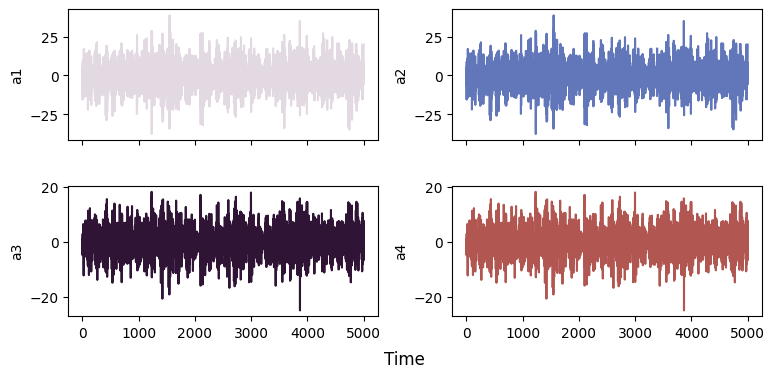

In [10]:
funcs.draw_features(data, 5000)

##### Split data into samples

In [5]:
split_proportion = {'train': 0.7, 'validation': 0.1, 'test': 0.2}

In [6]:
train_data = data.values[:round(split_proportion['train']*data.shape[0]), :]
valid_data = data.values[round(split_proportion['train']*data.shape[0]):round((split_proportion['train']+split_proportion['validation'])*data.shape[0]), :]
test_data = data.values[-round(split_proportion['test']*data.shape[0]):, :]

print(f'Train sample size: {train_data.shape[0]}\nValidation sample size: {valid_data.shape[0]}\nTest sample size: {test_data.shape[0]}')

Train sample size: 74726
Validation sample size: 10676
Test sample size: 21350


##### Normalization

In [7]:
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [8]:
train_data = scaler.transform(train_data)
valid_data = scaler.transform(valid_data)
test_data = scaler.transform(test_data)

#### Create time series generators

In [9]:
look_back_length = 50
horizon = 50
n_features = len(features_names)

model_params = foras.DeepForecasterParameters(n_features=n_features,
                                      look_back_length=look_back_length,
                                      horizon=horizon)

In [10]:
train_ts = foras.TSGenerator(train_data, model_params)
valid_ts = foras.TSGenerator(valid_data, model_params)
test_ts = foras.TSGenerator(test_data, model_params)

print(f'Train timeseries: data shape = {train_ts.data.shape}, targets shape = {train_ts.targets.shape},\n'
      f'Validation timeseries: data shape = {valid_ts.data.shape}, targets shape = {valid_ts.targets.shape},\n'
      f'Test timeseries: data shape = {test_ts.data.shape}, targets shape = {test_ts.targets.shape}\n')

Train timeseries: data shape = (74627, 50, 4), targets shape = (74627, 50, 4),
Validation timeseries: data shape = (10577, 50, 4), targets shape = (10577, 50, 4),
Test timeseries: data shape = (21251, 50, 4), targets shape = (21251, 50, 4)


### Create model and hyperparameters optimization

##### Create tuner for optimization and set search space

In [19]:
tuner = foras.DeepForecasterTuner(model_params)
tuner.set_tuned_hps(block_type=['LSTM', 'GRU'],
                    n_rec_layers=[1,2],
                    units=[[128, 64], [32, 16]],
                    dropout=[0.0, 0.001, 0.01],
                    hidden_activation=['tanh', 'relu'],
                    output_activation=['linear', 'sigmoid'])
print(tuner.hp_choices)

{'block_type': ['LSTM', 'GRU'], 'units': {'units_0': [128, 64], 'units_1': [32, 16]}, 'dropout': [0.0, 0.001, 0.01], 'n_rec_layers': [1, 2], 'hidden_activation': ['tanh', 'relu'], 'output_activation': ['linear', 'sigmoid']}


##### Search 3 best models with Bayesian optimization algorithm

In [21]:
best_models = tuner.find_best_models(train_ts.get_data(), train_ts.get_targets(),
                                     validation_data=(valid_ts.get_data(), valid_ts.get_targets()), 
                                     tuner_type='BayesianOptimization',
                                     max_trials=10,
                                     epochs=5,
                                     n_models=3,
                                     batch_size=128)

Trial 10 Complete [00h 05m 37s]
val_loss: 0.007908696308732033

Best val_loss So Far: 0.006097054574638605
Total elapsed time: 01h 04m 23s
INFO:tensorflow:Oracle triggered exit
Results summary
Showing 3 best trials

Trial 00 summary
Hyperparameters:
n_rec_layers: 2
block_type: GRU
units_0: 128
hidden_activation: tanh
dropout: 0.0
output_activation: sigmoid
units_1: 32
Score: 0.006097054574638605

Trial 01 summary
Hyperparameters:
n_rec_layers: 2
block_type: LSTM
units_0: 128
hidden_activation: tanh
dropout: 0.001
output_activation: sigmoid
units_1: 32
Score: 0.006135314237326384

Trial 03 summary
Hyperparameters:
n_rec_layers: 2
block_type: LSTM
units_0: 64
hidden_activation: tanh
dropout: 0.01
output_activation: sigmoid
units_1: 32
Score: 0.006234291475266218


##### Save best deep forecasting model configurations

In [12]:
config_directory = 'ai_models/forecastate/configs'

In [ ]:
configurations_names = []

if not os.path.exists(config_directory):
    os.makedirs(config_directory)

for i, model in enumerate(best_models):
    filename = f'{config_directory}/{data_name.lower()}_{model.default_name}_{i}.json'
    configurations_names.append(f'{data_name.lower()}_{model.default_name}_{i}.json')

    model.save_model_config(filename)
    print(f'Model {i} configuration save to', filename)

### Train deep forecasting models

In [24]:
model_directory = 'ai_models/forecastate/ready'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
histories = []

In [25]:
configurations_names = [filename for filename in os.listdir(f'{config_directory}') if filename.find(data_name.lower())==0]
print(configurations_names)

['h30hz90_gru_128_32_d00_0.json', 'h30hz90_lstm_128_32_d0001_1.json', 'h30hz90_lstm_64_32_d001_2.json']


In [27]:
for i, config in enumerate(configurations_names):
    # Get model from configuration
    model = foras.DeepForecaster(from_file_config=f'{config_directory}/{config}')
    print(model.default_name)
    # Train model
    model.train(train_ts.get_data(), train_ts.get_targets(),
                validation_data=(valid_ts.get_data(), valid_ts.get_targets()),
                batch_size=128, n_epochs=30, early_stop_patience=5)
    # Get train history
    histories.append(model.history)
    # Save trained model
    model_filename = f'{model_directory}/{data_name.lower()}_{model.default_name}_{i}.keras'
    model.save_model(model_filename)
    print(f'Model {i} save to', model_filename)

gru_128_32_d00
Epoch 1/30
584/584 [==============================] - 121s 192ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 2/30
584/584 [==============================] - 101s 173ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/30
584/584 [==============================] - 90s 155ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 4/30
584/584 [==============================] - 93s 159ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 5/30
584/584 [==============================] - 100s 172ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 6/30
584/584 [==============================] - 88s 150ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 7/30
584/584 [==============================] - 92s 157ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/30
584/584 [==============================] - 91s 156ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 9/30
584/584 [==============================] - 84s 144ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/30
584/584 [==============================] - 

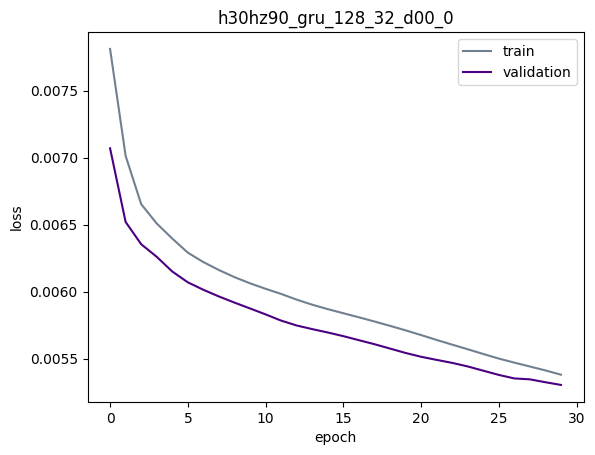

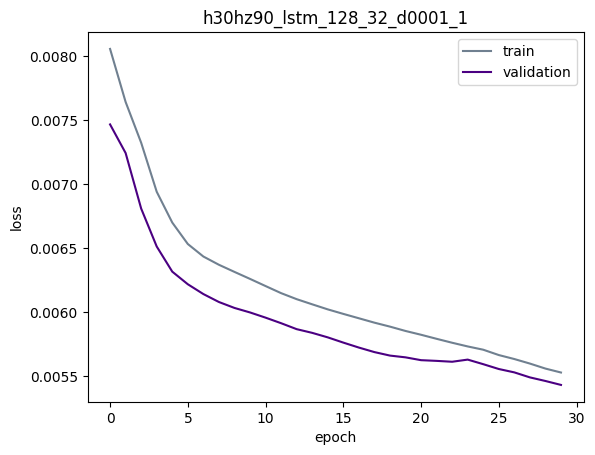

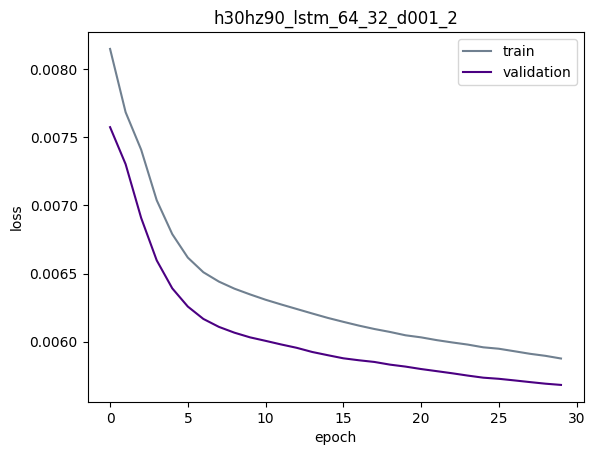

In [29]:
for config, history in zip(configurations_names, histories):
    plt.plot(history.history['loss'], color='slategrey')
    plt.plot(history.history['val_loss'], color='indigo')
    plt.title(config.replace('.json', ''))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [13]:
directory = 'ai_models/forecastate/ready'
best_models = []

for file in os.listdir(directory):
    if data_name.lower() in file:
        print(file)
        model = foras.DeepForecaster(from_file=f'{directory}/{file}')
        best_models.append(model)

h30hz90_gru_128_32_d00_0.keras
h30hz90_lstm_128_32_d0001_1.keras
h30hz90_lstm_64_32_d001_2.keras


### Evaluation

#### Forecasting data length is equal to horizon

In [14]:
forecasting_data_length = horizon
print(f'forecasting_data_length={forecasting_data_length}')

forecasting_data_length=50


In [15]:
current_batch = test_ts.get_data()
print('Data for forecasting:', current_batch.shape)

Data for forecasting: (21251, 50, 4)


##### Create estimator

In [16]:
estimator = foras.ForecastEstimator(features_names=features_names)
estimator.set_true_values(test_ts.get_targets())
estimator.set_first_batch(test_ts.get_data(window_id=0))

##### Deep forecasting

In [17]:
for model in best_models:
    print(model.default_name)
    pred = model.forecasting(current_batch,
           forecasting_data_length=forecasting_data_length)
    estimator.set_pred_values(pred, model_name=model.default_name)

gru_128_32_d00
2126/2126 [==============================] - 31s 14ms/step
lstm_128_32_d0001
2126/2126 [==============================] - 52s 24ms/step
lstm_64_32_d001
2126/2126 [==============================] - 36s 16ms/step


##### Naive method

In [20]:
nm = foras.NaiveForecaster(model_params)
estimator.set_pred_values(nm.forecasting(current_batch,
           forecasting_data_length=forecasting_data_length),
                          model_name='naive')

Forecasting: 100%|██████████| 21251/21251 [03:14<00:00, 109.40it/s]


##### Evaluation

In [21]:
estimator.estimate()
estimator.quality

,gru_128_32_d00_MSE,gru_128_32_d00_RMSE,gru_128_32_d00_MAE,gru_128_32_d00_R2,lstm_128_32_d0001_MSE,lstm_128_32_d0001_RMSE,lstm_128_32_d0001_MAE,lstm_128_32_d0001_R2,lstm_64_32_d001_MSE,lstm_64_32_d001_RMSE,lstm_64_32_d001_MAE,lstm_64_32_d001_R2,naive_MSE,naive_RMSE,naive_MAE,naive_R2
a1,0.003913,0.062556,0.047857,0.335173,0.004098,0.064014,0.048978,0.303812,0.004263,0.065292,0.050062,0.275737,0.011836,0.108792,0.083854,-1.010802
a2,0.006919,0.083178,0.063910,0.226608,0.007045,0.083932,0.064536,0.212534,0.007199,0.084849,0.065195,0.195222,0.017985,0.134109,0.104002,-1.010458
a3,0.006079,0.077968,0.060135,0.322088,0.006261,0.079125,0.061065,0.301807,0.006478,0.080488,0.062166,0.277560,0.018147,0.134709,0.103891,-1.023659
a4,0.005965,0.077235,0.059664,0.398647,0.006183,0.078631,0.060694,0.376710,0.006498,0.080611,0.062302,0.344915,0.019677,0.140273,0.108462,-0.983601
ALL_FEATURES,0.005719,0.075234,0.057891,0.320629,0.005896,0.076425,0.058818,0.298716,0.006110,0.077810,0.059931,0.273358,0.016911,0.129471,0.100052,-1.007130


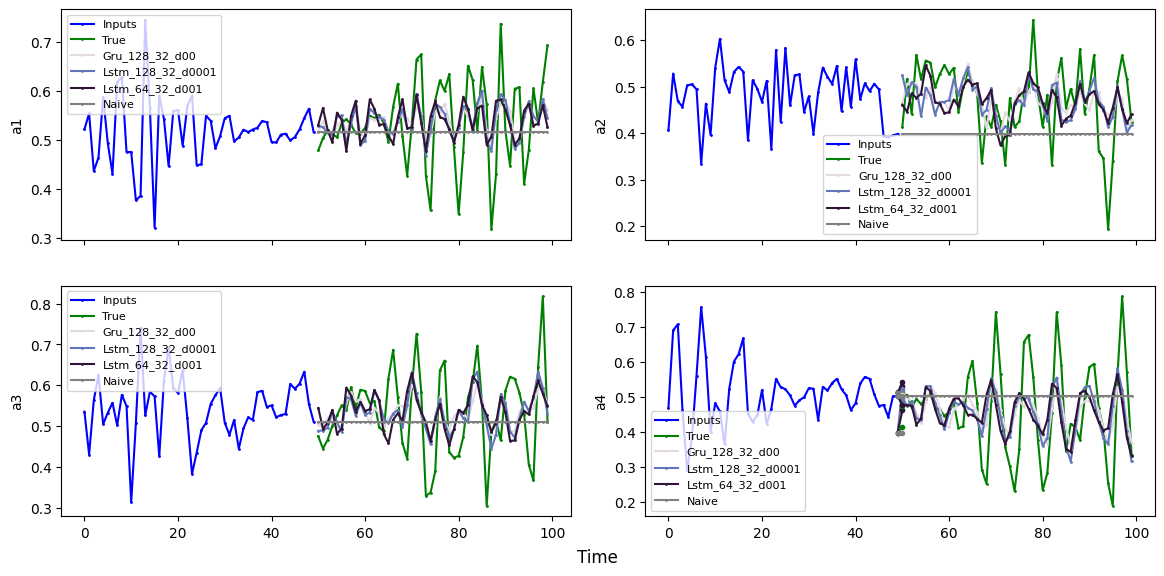

In [22]:
estimator.draw(size=1)